In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

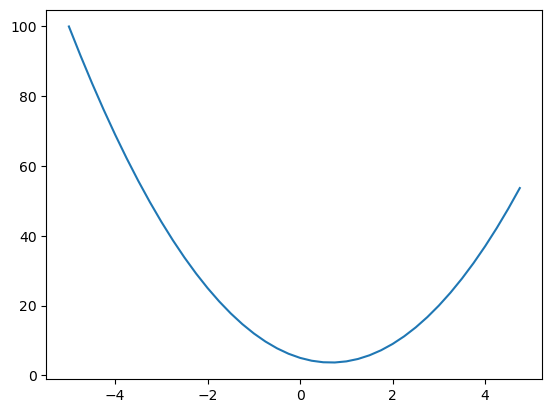

In [4]:
xs = np.arange(-5,5,0.25)
xs
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.000001
x = 2/3
(f(x+h) - f(x))/h
#f(a+h)-f(a)/h is the derivative formula/

2.999378523327323e-06

In [6]:
#complex,function with 3 scalar inputs
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [7]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)#slope wrt a



d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [8]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)#slope wrt b


d1 4.0
d2 4.0002
slope 2.0000000000042206


In [9]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)#slope wrt c


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [10]:
#data structure used for storing the data

class Value:
    
    def __init__(self,data,_children = (),_op = '',label = ''): #children is empty tuple
        self.data = data
        self._prev = set(_children) #set
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other) #to allow for a + 1 type of operations(a is Value, 1 is int)
        out = Value(self.data + other.data,(self,other),'+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    

    def __pow__(self, other): #will be called when exponentiation is called
        assert isinstance(other, (int, float)), "only supports float/int"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad #nx^(n-1)
        out._backward = _backward

        return out

    def __rmul__(self, other): #other * self, because 2 * a wont work, a * 2 does. rmul will make 2 * a to a * 2, which it knows
        return self * other
    def __radd__(self, other):
        return self + other

    def __truediv__(self, other): #self / other
        return self * other ** -1

    def __neg__(self): #-self
        return self * -1

    def __sub__(self, other): #self - other
        return self + (-other)
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out  

    def backward(self):
        o.grad = None #base case for init (changed from 1.0 to None due to Torch issue)

        #topological sort for backward pass automation
        #starts at o,lays children in left to right,then finally the parent is added
        #topological graph is graph in which all the nodes only move to right
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward() #since the graph given by fun would be from O to start, we want reverse
                
        

#if a + b is written, python will internally call a.__add__(b),thats why
#for special operators we use __add__ in def __add__
# a * b + c  ===  (a.__mul__(b)).__add__(c)|


a = Value(2.0,label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10.0,label = 'c')
e = a * b;
e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0,label = 'f')
L = d * f; L.label = 'L'


In [11]:
a - b

Value(data=5.0)

In [12]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges


def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {"rankdir": 'LR'}) #LR: Left to Right

    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label ,n.data,n.grad),shape = 'record')
        if n._op:
            #if this value is a result of some operation,create an op node for it
            dot.node(name = uid + n._op,label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)


    return dot
            
        
    

In [13]:
f.grad = 4.0 
c.grad = -2.0 
e.grad = -2.0
d.grad = 1.0
a.grad = 6.0 
b.grad = -4.0
L.grad = 1.0

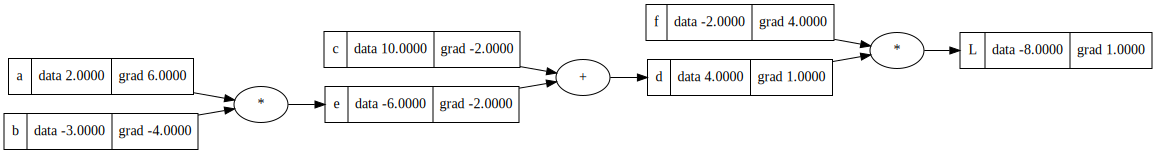

In [14]:
draw_dot(L)

forward pass is done. multiple variable goes through operations and then some
result L is created. L is loss function.
now doing backpropagation and calculating gradient by calulating derivate wrt previous nodes

f.grad = 4.0 #since L = d * f
d.grad = -2.0
L.grad = 1.0 #derivate of L wrt L

dd/ dc? 1.0
dd/de ? 1.0
d = c + e

dL/dc = dL/dd * dd/dc
as there is  "+" operation,it basically routes d's derivate to e and c
dL/dc = -2
c.grad = -2.0
e.grad = -2.0

a.grad = 6.0
b.grad = -4.0(to find)

similary for a and b is found

manual backpropagation by upgrading x.grad
iterated over all nodes and applied chain rule
applying inputs to make L go up

if you want L to go up, 'a' should be increased by gradient. it should be put in direction of L along with a small step (0.01)
we have nudged all of the nodes in direction of gradient,we expect L to increase in value.

In [15]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
#these are all leaf nodes. we expect L to go up(become less negative) when nudged by gradient.

e = a * b
d = e + c
L = d * f
print(L.data)

-7.286496


In [16]:
def lol():

    h = 0.0001
    
    a = Value(2.0,label = 'a')
    b = Value(-3.0,label = 'b')
    c = Value(10.0,label = 'c')
    e = a * b;
    e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0,label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0  ,label = 'a')
    b = Value(-3.0,label = 'b')
    c = Value(10.0,label = 'c')
    e = a * b;
    e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0,label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print((L2 - L1)/h)

lol()

-1.9999999999953388


In [17]:
 #backpropagate through neural net. multilayer perceptron models, summation of wixi + b and activation function etc

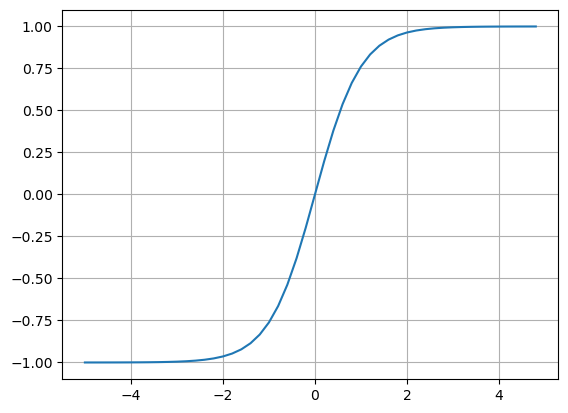

In [18]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));plt.grid();

In [19]:
#inputs x1,x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
#weights w1,w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")
#bias of the neuron
b = Value (6.88137358, label = 'b') #bias was changed,numbers will come better with this value acc to Andrej
#x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#activation fun
o = n.tanh();o.label = 'o'
o.backward()

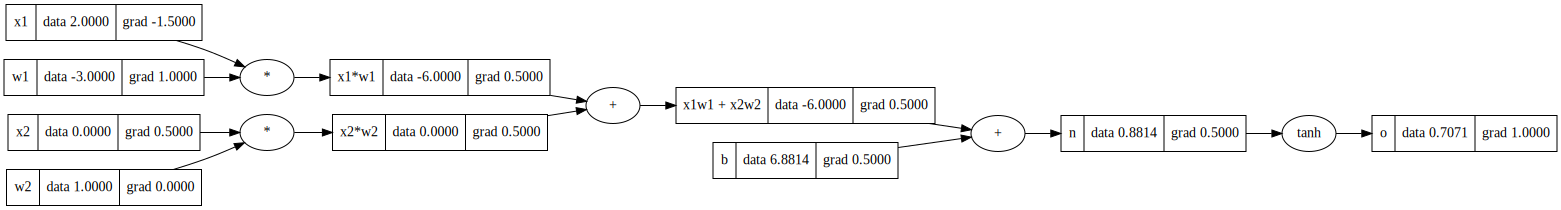

In [20]:
draw_dot(o)

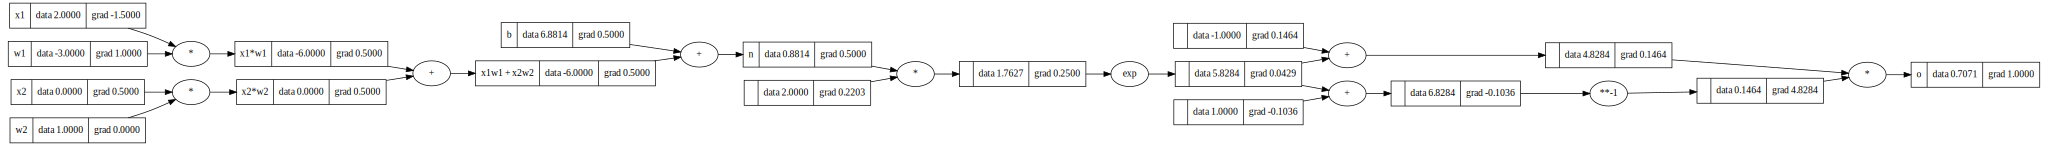

In [21]:
#inputs x1,x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
#weights w1,w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")
#bias of the neuron
b = Value (6.88137358, label = 'b') #bias was changed,numbers will come better with this value acc to Andrej
#x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#activation fun
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o' #tanh is broken into another formula)

o.backward()
draw_dot(o)

In [22]:
#backpropagation

In [23]:
#automatic bypass(converted to backward fun in Value)
o.backward()

In [24]:
o.grad = 1.0 #initialised for base case, otherwise it is 0.0
o._backward()

In [25]:
n._backward()

In [26]:
b._backward()

In [27]:
x1w1x2w2._backward()

In [28]:
x2w2._backward()
x1w1._backward()

In [29]:
#below 5 cells were executed to backpass manually, above ones are to show the function backward,above that automatic backpass

In [30]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [31]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [32]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [33]:
x2w2.grad = 0.5
x1w1.grad = 0.5

In [34]:
n.grad = 1 - o.data ** 2

In [35]:
o.grad = 1.0 #do/do

In [36]:
#o = tanh(n),what is do/dn (1-tanh(n)^2)= 1 - o**2, rerun draw_dot

#bug reproduction

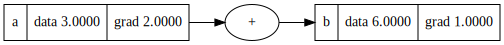

In [37]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)
#there should be two a's, also gradient of a should be 2
#b is out of __add__, in this case, self and other are same, thus making it point to the same object,
##it is overriding values in def _backward

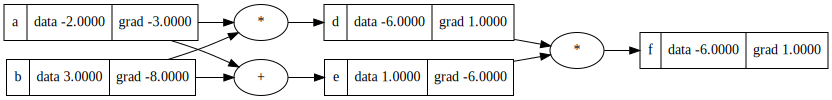

In [38]:
#complex bug

a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)
#Gradients are wrong. this occurs because the variable is used more than once, overriding of gradients takes place. to fix it, 
#we accumulate the gradients instead of just statically putting a value. the idea of summing comes from the chain rule wiki page

In [39]:
#everything accept x1w1 example and Value was deleted. except these, everything is redundant

In [40]:
#doing the same thing above bug in Pytorch
import torch

x1 = torch.Tensor([2.0]).double() ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ;w2.requires_grad = True
b = torch.Tensor([6.881373580]).double() ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")

print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('x1',w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
x1 1.0000002567688737


pytorch is doing the same shit as we did. we implemented code ground up. it uses tensors to achieve this. here, the tensors basically hold scalar values. they are typecasted to double as Python holds values usually in float32 ,we need better convenience so we typecast. Explicitly also stating that they need gradients because they are leaf nodes.


In [41]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [42]:
o.item()

0.7071066904050358

In [43]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [44]:
#we did pytorch on autograd,now on NN

In [59]:
import random
class Neuron:
    
    def __init__(self, nin): #number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x): #call is called when object direct is called with x eg. n(x)
        #w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)),self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout): #number of outputs(neurons in each layer)
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 
    def parameters(self):
        #return [p for neuron in self.neurons for p in neurons.parameters]
        params = []
        for neurons in self.neurons:
            ps = neurons.parameters()
            params.extend(ps)
        return params

class MLP:

    def __init__(self, nin, nouts):#list of nouts, defines the sizes of all layers in mlp
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] #creating layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) #sequential calling for output
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
    #x = [2.0 3.0] n = Layer(2,3) n(x):::? for creating a layer with 2 inputs(x),
    #3 neurons in each layer
    
        

In [60]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1]) #3 inputs, two layers of 4 nodes, one output node
n(x)

Value(data=-0.30881480383027254)

In [63]:
n.parameters()

[Value(data=0.7562630915557531),
 Value(data=0.21294491401616167),
 Value(data=-0.47421732534315186),
 Value(data=0.9827981844445486),
 Value(data=-0.11058620565550514),
 Value(data=-0.651794932415021),
 Value(data=0.27761693393728915),
 Value(data=0.15133018319554448),
 Value(data=0.11520101633243152),
 Value(data=0.9808852558836136),
 Value(data=-0.4194568891884842),
 Value(data=-0.23320627880044076),
 Value(data=-0.8832500953178841),
 Value(data=0.02195061548764876),
 Value(data=-0.9426445379149166),
 Value(data=-0.5468939028473725),
 Value(data=-0.7222302932735887),
 Value(data=-0.12402404690480218),
 Value(data=0.4813830753113155),
 Value(data=0.7799099992363208),
 Value(data=0.8151628894048057),
 Value(data=0.027792359524041688),
 Value(data=-0.4016757314431856),
 Value(data=0.0955675292066267),
 Value(data=-0.8119708243155273),
 Value(data=-0.535858603666187),
 Value(data=0.856969488323196),
 Value(data=0.15413259857552508),
 Value(data=-0.08638410909708782),
 Value(data=-0.9379

In [109]:
#basic binary classifier net, ys is targets. when given xs[0] (2,3,-1] the
#output should be ys[0] 1.0 and so on


xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]



In [110]:
#checks how well NN is performing,rmse loss (ygt = ground truth),loss is to be minimised
#final automatic function
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    #backward pass
    for p in n.parameters():
        p.grad = 0.0 #(zero grad in pytorch)
    loss.backward()
    #update
    for p in n.parameters(): 
        p.data += -0.05 * p.grad 
    print(k, loss.data)
    #errors occur due to overlapping functions, will have to remove

OverflowError: math range error

In [105]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.419066689302909)

In [91]:
loss.backward()

In [72]:
n.layers[0].neurons[0].w[0].grad

0.00044189975178435606

In [73]:
n.layers[0].neurons[0].w[0].data

0.7562630915557531

In [92]:
#doing gradient descent manually

for p in n.parameters(): #0.01 is learning rate
    p.data += -0.01 * p.grad #small step size towards lesser loss. vector is pointing at increasing loss, -ve sign points it to minimize the loss


In [77]:
n.layers[0].neurons[0].w[0].grad

0.00044189975178435606

In [94]:
ypred

[Value(data=0.8337972935164136),
 Value(data=-0.856770816433582),
 Value(data=0.011664799036840388),
 Value(data=0.7844368453004499)]

In [ ]:
#loss.backward; gradient descent; check loss, repeat. forward pass,backward pass,update. (gd steps)

In [95]:
n.parameters()

[Value(data=0.7640785363583494),
 Value(data=0.23086750727600938),
 Value(data=-0.45125377236515324),
 Value(data=1.00122420687027),
 Value(data=-0.09498855112678453),
 Value(data=-0.6215687883142949),
 Value(data=0.37655514734529105),
 Value(data=0.19289517933082384),
 Value(data=0.07516881952228452),
 Value(data=0.8839756822226482),
 Value(data=-0.5940572865933251),
 Value(data=-0.3368087449448139),
 Value(data=-0.8893585004131135),
 Value(data=0.026052973850940367),
 Value(data=-0.9274051066378437),
 Value(data=-0.564571045770508),
 Value(data=-0.5048615516094608),
 Value(data=-0.4000945769466948),
 Value(data=0.7769321739826403),
 Value(data=0.7210703467711947),
 Value(data=0.9987331825966305),
 Value(data=0.21025209826248173),
 Value(data=-0.6198266860010664),
 Value(data=0.3379301980091713),
 Value(data=-0.8561882780837177),
 Value(data=-0.3745159293037077),
 Value(data=0.8810158695725742),
 Value(data=0.12665259582873103),
 Value(data=-0.056303795797175246),
 Value(data=-0.94514

In [ ]:
#redo last 15mim.